In [2]:
from math import lgamma
from numba import jit
import numpy as np
from scipy.stats import beta

# Описание работы Байесовских алгоритмов

## Принцип работы
Предполагается некое априорное распределения метрик (биномиальные, нормальное,
экспоненциальное и т.д.). Затем, используя полученные данные (новую информацию), мы
пересчитываем распределения для метрик. При помощи распределения

## Основные критерии принятия решений

Основная проблема Байесовских тестов по сравнению с классическими - проблема
контроля ошибки 1 и 2 рода. Особенно это проявляется в случае ранней остановки
алгоритма (когда мы заканчиваем эксперимент при достижении определенных значений
критериев). Ниже будут описаны основные критерии принятия решений
в случае байесовских тестов
(как для алгоритма Томпсона, так и для разбивки 50 на 50).

### Вероятность превосходства для конверсии
Английские термины: *chance to beat control*, *probability superiority*

В случае алгоритма на конверсию у нас в качестве априорного распределения берется
биномиальное. Для того чтобы пересчитать апостериорную вероятность для биномиального
распределения, используется сопряженное ему бета-распределение.
Вероятность превосходства  можно посчитать двумя способами: по точной формуле или при помощи генерации
случайных величин из бета-распределения с параметрами на момент пересчета.

Точная формула описана [здесь](https://www.johndcook.com/UTMDABTR-005-05.pdf).

Метод сэмплирования следующий:

1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Смотрим сумму положительных значений для теста
4. Суммируем и делим на число сэмплирований

In [3]:
from src.bayesian import *
# Посмотрим на результаты, полученные разными способами
alphas, betas = [10, 20], [100, 200]
print(f"Точная формула: {calc_prob_between(alphas, betas)}")
print(f"Сэмплирование: {chance_to_beat_all(np.array(alphas), np.array(betas))}")

Точная формула: 0.5148327134706592
Сэмплирование: [0.485122 0.515453]


Отметим, что сэмплирование приводит примерно к тому же результату, но при большом
количестве генераций случайных распределений (например, 1 млн).

Важный момент, который важно понять - эта вероятность превосходства
верна только для текущего набора наблюдений. Другими словами,
мы не знаем, как все изменится при добавлении других данных.
А вот как раз в случае p-value мы можем предположить, в скольких
случаях выигрышный на данный момент вариант может на самом
деле оказаться проигрышным в будущем.

Экспериментальным путем однако выявлено, что в случае
Байесовских тестов без остановки для контроля ошибок
1,2 рода, вероятности превосходства вполне достаточно.

### Ожидаемые потери
Английский термин: *expected losses*

Данный критерий описан в [статье](https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#1)
*Chris Stucchio* - разработчика
самого лучшего инструмента для АБ-тестов
*Visual Website Optimizer*.


Ожидаемые потери контрольного / тестового варианта - сколько мы ожидаем в среднем потерь в случае,
если выберем контрольный / тестовый вариант. Считается похожим
образом, как и сэплированная вероятность превосходства:
1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Отрицательной разнице присваиваем 0
4. Суммируем и делим на число сэмплирований

Определяем некий порог и в бой!

### Размер эффекта
Английский термин: *effect size*

Размер эффект дополняет показатель разницы конверсий и
рассчитывается по такой формуле:

$
\frac{\hat{p_1} - \hat{p_2}} {
[\hat{p_1} * (1 - \hat{p_1}) * (n_1 - 1) + \hat{p_2} *
(1 - \hat{p_2}) * (n_2 - 1)] /
(n_1 + n_2 - 2)}
$

### Достоверные интервалы
Английский термин: *credible intervals*

Достоверные интервалы являются аналогом доверительных интервалов в случае
классических АБ-тестов. Однако, достоверные интервалы фиксируют
нашу текущую неопределенность о потенциальных значениях параметра и
могут быть интерпретированы как вероятностное утверждение о параметре.

Доверительные интервалы отражают неопределенность относительно
полученного нами интервала (т.е. содержит ли он истинное значение или нет).
Таким образом, их нельзя интерпретировать как вероятностное утверждение
об истинных значениях параметров.

Сравним интерпретацию 95% доверительного и достоверного интервала.

В случае доверительного интервала в 95% экспериментах истинное значение
параметра будет лежать в данном диапазоне.

В случае достоверного интервала 95% ВСЕХ ЗНАЧЕНИЙ лежит в этом диапазоне.

### Область практической эквивалентности
Английский термин: *ROPE - region of practical equivalence*

Данный критерий может помочь принять нулевую гипотезу - случай
отсутствия разницы между разными вариантами теста. Рекомендуемое значение
границ *ROPE* = +- 0.1 для размера эффекта.

Если *credible intervals* полностью лежат внутри ROPE, то
делаем вывод, что разницы нет.

## Пример реализации Байесовских тестов с разными критериями

Будем пользоваться пакетом abyes и собственными вычислениями
В этом пакете мы можем выбрать несколько критериев:
- decision_var = ['es' - effect size; 'lift' - разница эффектов]
- rule = ['loss', 'rope']

Возьмем конверсии с крайне маленькими различиями: 0.02 (контрольный вариант)
против 0.025 (тестовый вариант).


*** abyes ***

Method = analytic
Decision Rule = loss
Threshold of Caring = 0.001
Decision Variable = lift

Result is conclusive: B variant is winner!



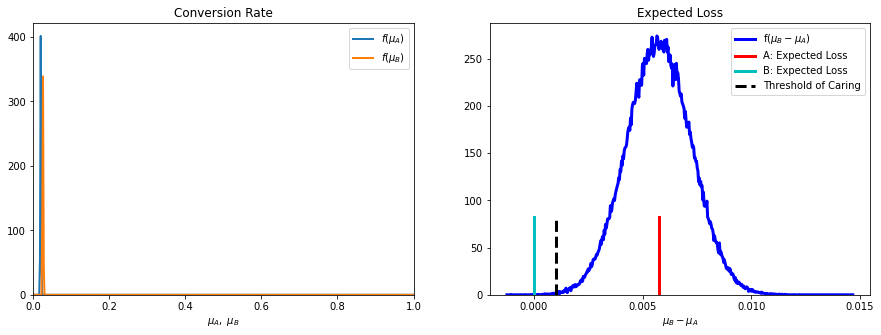

1

In [25]:
import abyes as ab
data = np.random.binomial([1, 1], [0.02, 0.025], size=(20000, 2))

exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='loss', toc=0.001, alpha=0.95, plot=True)
exp.experiment(data.T)

Видим, что по 20000 наблюдений недостаточно, чтобы определить такую разницу
для данных критериев. Попробуем другой критерий - ROPE.


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.1, 0.1)
Decision Variable = lift

* Result is conclusive: A and B variants are effectively equivalent!



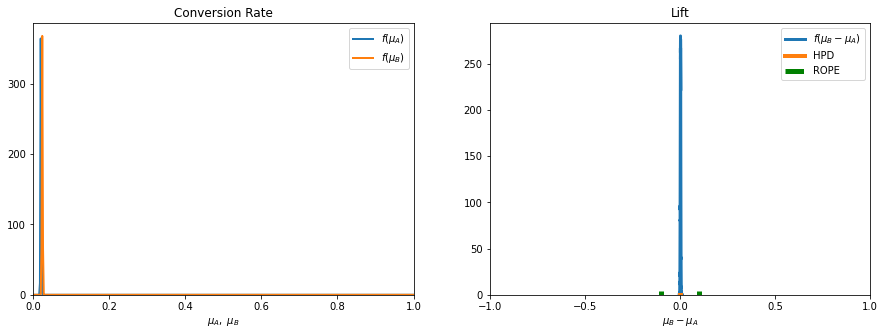

In [20]:
exp = ab.AbExp(method='analytic', decision_var = 'rope',
               rule='rope', rope=(-0.1,0.1), alpha=0.95, plot=True)
results = exp.experiment(data.T)

Аналогично - результат теста - между вариантами нет различий.

Вычислим теперь все показатели самостоятельно.

In [26]:
# Effect size
from src.bayesian import *
effect_size(data)

,,n1,n2,p1,p2,var1,var2,effect_size
var1,var2,,,,,,,
0,1,20000,20000,0.02,0.02575,0.0196,0.025087,-0.038467


In [28]:
alphas / (alphas + betas)

array([0.02   , 0.02575])

In [35]:
alphas

array([400, 515])

In [36]:
(alphas + betas) ** 2

array([400000000, 400000000])

In [41]:
betas * alphas

array([ 7840000, 10034775])

In [30]:
(alphas * betas) / (((alphas + betas) ** 2) * (alphas + betas + 1))

array([9.79951002e-07, 1.25428416e-06])

In [33]:
data.var(axis=0)

array([0.0196    , 0.02508694])

In [27]:
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
print(f"Chance to beat control: {np.round(chance_to_beat_all(alphas, betas), 3)}")

Chance to beat control: [0. 1.]


In [16]:
print(f"Expected Losses: {np.round(expected_losses_all(alphas, betas), 3)}")

Expected Losses: [0.004 0.   ]


In [17]:
print(f"Expected Related Losses: "
      f"{np.round(expected_related_losses_all(alphas, betas), 3)}")

Expected Related Losses: [ 0.176 -0.146]


In [18]:
print(f"HDI for difference: "
      f"{hdi_mc(beta(alphas[0], betas[0]).rvs(size=int(1e6)) - beta(alphas[1], betas[1]).rvs(size=int(1e6)))}")

HDI for difference: [-0.00599147 -0.00113715]


In [19]:
data.mean(axis=0)

array([0.0205 , 0.02405])